# Seq2Class Model

Jose Amezquita and Jon Amitai'<br><br>
NOTE: Potentially don't need to tokenize data as each phrase is its own "word"<br>
TODO: Add Attention: Hypothesis: Won't make big difference<br>
TODO: Add Dropout layer<br>
NOTE: Do I need 2 inputs for the encoder?<br>
NOTE: Can I weight the encoder more towards the context or the anchor?(Different embedding layers with different sizes)<br>
CONCERN: Val accuracy starts high<br>
NOTE: Could more Dense layers help?(In decoder probably)<br>
NOTE: Does LSTM or GRU make a difference?(I don't think it really would)<br>
TODO: Pearson Correlation Coefficient<br>
NOTE: Does the ID help?<br>

NOTE: GRU Encoder seems better than SimpleRNN Encoder<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive') #mounts google colab to my drive. Can be commented out when running locally

%cd /content/drive/MyDrive/"Colab Notebooks"/"us-patent-phrase-to-phrase-matching"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/us-patent-phrase-to-phrase-matching


In [ ]:
!pip install tensorflow==2.4.0
!pip install numpy==1.19.5

     |████████████████████████████████| 497.5 MB 15 kB/s 
     |████████████████████████████████| 15.7 MB 37.9 MB/s 
     |████████████████████████████████| 462 kB 41.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
from tqdm.notebook import tqdm
import pandas
from IPython.display import display
from sklearn.model_selection import train_test_split

# Data Preprocessing

#### Load and Split Data

In [3]:
def load_data(path, test=False):
    data = pandas.read_csv(path)
    if not test:
        data = data.drop(['id'], axis = 1)
        # display(data)
        # data = data.to_numpy()

        # ah = data.loc[data['score'] == .5]

        # ah.to_csv("example.csv", index=False)

        data_output = data["score"]
        data_input = data.drop(['score'], axis=1)
        return data_input, data_output

    else:
        return data

train_data, train_scores = load_data("train.csv")
test_data = load_data("test.csv", True)



display(train_data.shape)
# display(train_scores)
display(test_data.shape)

#for testing purposes use less data
# train_data = train_data[:10000]
# train_scores = train_scores[:10000]

data_train, data_val, scores_train, scores_val = train_test_split(train_data, train_scores, test_size=0.2)
data_train, data_ver, scores_train, scores_ver = train_test_split(data_train, scores_train, test_size=0.2)

print('The size of the training set:', len(data_train))
print('The size of the validation set:', len(data_val))
print('The size of the verification set:', len(data_ver))
print('The size of the test set:', len(test_data))

(36473, 3)

(36, 4)

The size of the training set: 23342
The size of the validation set: 7295
The size of the verification set: 5836
The size of the test set: 36


In [4]:
len(train_data['context'].unique())

106

### Preprocess Data

In [5]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category

nlp_en = spacy.load('en_core_web_sm')

def tokenize(text):
    doc = nlp_en(text.lower())
    return [token.text for token in doc]

def preprocess(texts):
    return [tokenize(text) for text in tqdm(texts, desc="Preprocessing Data")]

def generate_vocab(tokenized_anchor, tokenized_target, contexts):
    tokenized_anchor = np.array(tokenized_anchor)
    tokenized_target = np.array(tokenized_target)
    vocab1 = list(chain.from_iterable(tokenized_anchor))
    vocab2 = list(chain.from_iterable(tokenized_target))
    vocab = np.concatenate((vocab1, vocab2, contexts))
    # unique, counts = np.unique(vocab1, return_counts=True)
    # print(dict(zip(unique,counts)))
    # print(vocab1.shape)
    return list(set(vocab))
#get vocab for entire dataset
anchor = train_data['anchor'].to_numpy()
target = train_data['target'].to_numpy()
contexts = train_data['context'].to_numpy()

anchor_tokens = preprocess(anchor)
target_tokens = preprocess(target)

vocab = generate_vocab(anchor_tokens, target_tokens, contexts)
vocab.insert(0, "<unk>")
token2idx = {token: idx for idx, token in enumerate(vocab)}

print("Vocab Length:", len(vocab))
print(vocab)

Preprocessing Data:   0%|          | 0/36473 [00:00<?, ?it/s]

Preprocessing Data:   0%|          | 0/36473 [00:00<?, ?it/s]

Vocab Length: 9037
['<unk>', 'rating', 'optional', 'increasing', 'unusual', 'laughing', 'clipboard', 'repulsive', 'jumpers', 'collected', 'photolytic', 'dihydrate', 'levels', 'vulcanized', 'converter', 'studio', 'extensions', 'childrens', 'approval', 'hose', 'signalling', 'bugs', 'events', 'enter', 'treasure', 'bullets', 'atom', 'tig', 'store', 'solution', '1', 'dsdna', 'gadgets', 'vent', 'encircle', 'truss', 'dunaliella', 'stack', 'oxymeter', 'indications', 'sulfa', 'inflators', 'mall', 'freeform', 'firmware', 'conduction', 'code', 'serous', 'resolution', 'orthopedic', 'toggle', 'sandwich', 'elevational', 'chrysaora', 'vehicular', 'infusion', 'belt', 'body', 'vesicle', 'asphalt', 'refinery', 'convert', 'pallet', 'corral', 'bump', 'C04', 'skates', 'butyl', 'to', 'pectin', 'airstream', 'singer', 'sunscreen', 'backrest', 'switched', 'proximity', 'maglev', 'plumbing', 'electronics', 'brakes', 'series', 'androgenic', 'fusing', 'proteins', 'desirable', 'finline', 'tank', 'eyes', 'microwave'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
anchor_train = data_train['anchor'].to_numpy()
target_train = data_train['target'].to_numpy()
context_train = data_train['context'].to_numpy()

anchor_val = data_val['anchor'].to_numpy()
target_val = data_val['target'].to_numpy()
context_val = data_val['context'].to_numpy()

anchor_ver = data_ver['anchor'].to_numpy()
target_ver = data_ver['target'].to_numpy()
context_ver = data_ver['context'].to_numpy()


# print(token2idx)

# print(target_tokens)
# print(tokenize(target[0]))

train_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_train, target_train, context_train)),desc="Processing Train Set:")]
val_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_val, target_val, context_val)),desc="Processing Validation Set:")]
ver_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_ver, target_ver, context_ver)),desc="Processing Verification Set:")]

Processing Train Set::   0%|          | 0/23342 [00:00<?, ?it/s]

Processing Validation Set::   0%|          | 0/7295 [00:00<?, ?it/s]

Processing Verification Set::   0%|          | 0/5836 [00:00<?, ?it/s]

In [7]:
print("Train Set Size:", len(train_set))
print("Validation Set Size:", len(val_set))
print("Verification Set Size:", len(ver_set))

Train Set Size: 23342
Validation Set Size: 7295
Verification Set Size: 5836


# Model

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 

# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import matplotlib.pyplot as plt 

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2112615757271262257
]


In [9]:
vocab_len = len(vocab)
embedding_size = 300 #size of the embedding layer
hidden_size = 300 #size of the hidden layer
num_classes = 5

### Encoder

In [ ]:
#GRU

input1 = layers.Input(shape=(None,), name="Context_Input")
input2 = layers.Input(shape = (None, ), name="Anchor_Input")
embedding = layers.Embedding(input_dim=vocab_len, output_dim =  embedding_size, name="Encoder_Embedding")
embed1 = embedding(input1)
embed2 = embedding(input2)
# concatted = layers.Concatenate([embed1, embed2]))
encoder = layers.GRU(hidden_size//2, return_state=True, name="Encoder_RNN")
_, encoder_context_vector1 = encoder(embed1)
_, encoder_context_vector2 = encoder(embed2)

concatted = [layers.Concatenate()([encoder_context_vector1, encoder_context_vector2])]
attention = layers.Attention()([encoder_context_vector1, encoder_context_vector2])

print(concatted)
print(attention)



[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'concatenate_4')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='attention_1/MatMul_1:0', description="created by layer 'attention_1'")


In [10]:
#GRU

model2_input1 = layers.Input(shape=(None,))
# input2 = layers.Input(shape = (None, ), name="Anchor_Input")
model2_embedding = layers.Embedding(input_dim=vocab_len, output_dim =  embedding_size)
model2_embed1 = model2_embedding(model2_input1)
# embed2 = embedding(input2)
# concatted = layers.Concatenate([embed1, embed2]))
model2_encoder = layers.GRU(hidden_size, return_state=True)
_, m2_encoder_context_vector1 = model2_encoder(model2_embed1)
# _, encoder_context_vector2 = encoder(embed2)

encoder_context_vec = [m2_encoder_context_vector1, m2_encoder_context_vector1]
# attention = layers.Attention()([encoder_context_vector1, encoder_context_vector2])

print(encoder_context_vec)



[<KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'gru')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'gru')>]


### Decoder

In [ ]:
decoder_input = layers.Input(shape=(None,), name="Target_Input")
decoder_embedding = layers.Embedding(input_dim=vocab_len, output_dim=embedding_size, name = "Decoder_Embedding")
decoder_embeded = decoder_embedding(decoder_input)
decoder = layers.GRU(hidden_size, return_state=True, name="Decoder_RNN", dropout=0.2)
decoder_concat_layer = layers.Concatenate()
# decoder_vec = decoder_concat_layer([embed1, decoder_embeded])
_, decoder_state = decoder(decoder_embeded, initial_state = concatted)

decoder_attention = layers.Concatenate()([decoder_state, attention])

decoder_dense = layers.Dense(num_classes,activation="softmax", name = "Dense_Softmax_Layer")
# dense2 = layers.Dense(32)
drop = layers.Dropout(0.2)
# dense3 = layers.Dense(num_classes, activation="softmax")
decoder_output = decoder_dense(decoder_attention)
decoder_output = drop(decoder_output)
# decoder_output = dense2(decoder_output)
# decoder_output = drop(decoder_output)
# decoder_output = dense3(decoder_output)

print(decoder_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='dropout_1/Identity:0', description="created by layer 'dropout_1'")


In [11]:
decoder2_input = layers.Input(shape=(None,))
decoder2_embedding = layers.Embedding(input_dim=vocab_len, output_dim=embedding_size)
decoder2_embeded = decoder2_embedding(decoder2_input)
decoder2 = layers.Bidirectional(layers.GRU(hidden_size, return_state=True, recurrent_dropout = 0.2, dropout=0.2), merge_mode="concat")
# decoder_concat_layer = layers.Concatenate()
# decoder_vec = decoder_concat_layer([embed1, decoder_embeded])
decoder2_state_concatted,decoder2_state1,decoder2_state2 = decoder2(decoder2_embeded, initial_state = encoder_context_vec)

# print(decoder2_state_concatted)
# print(decoder2_state1)
# print(decoder2_state2)

# decoder_attention = layers.Concatenate()([decoder_state, attention])

decoder2_dense = layers.Dense(num_classes,activation="softmax")
decoder2_dense2 = layers.Dense(32)
decoder2_drop = layers.Dropout(0.2)
decoder2_output = decoder2_dense2(decoder2_state_concatted)
decoder2_output = decoder2_drop(decoder2_output)
decoder2_output = decoder2_dense(decoder2_output)
decoder2_output = decoder2_drop(decoder2_output)

print(decoder2_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")


### Training

In [12]:
learning_rate = 0.001#set learning rate
batch_size = 64#set batch size
num_epochs = 10#set number of epochs

In [13]:
max_anchor_len_train = max([len(data[0]) for data in train_set])
max_target_len_train = max([len(data[1]) for data in train_set])
max_anchor_len_val = max([len(data[0]) for data in val_set])
max_target_len_val = max([len(data[1]) for data in val_set])
max_anchor_len_ver = max([len(data[0]) for data in ver_set])
max_target_len_ver = max([len(data[1]) for data in ver_set])

# max_len = max([])

#get data ready for training, separaate data and pad it to same lengths
encoder_input1 = np.asarray([data[2] for data in train_set], dtype=np.int32)#context
# encoder_input1 = pad_sequences(encoder_input1, maxlen=max_anchor_len_train, padding='post')
encoder_input2 = [data[0] for data in train_set]#anchor
encoder_input2 = pad_sequences(encoder_input2, padding="post")
input_decoder = [data[1] for data in train_set]#target
input_decoder = pad_sequences(input_decoder, padding='post')
output_decoder = np.asarray(4*scores_train.to_numpy(), dtype=np.int32)

encoder_input1_val = np.asarray([data[2] for data in val_set], dtype=np.int32)#context
encoder_input2_val = [data[0] for data in val_set]#anchor
encoder_input2_val = pad_sequences(encoder_input2_val, padding="post")
input_decoder_val = [data[1] for data in val_set]#target
input_decoder_val = pad_sequences(input_decoder_val)
output_decoder_val = np.asarray(4*scores_val.to_numpy(), dtype=np.int32)

encoder_input1_ver = np.asarray([data[2] for data in ver_set], dtype=np.int32)#context
encoder_input2_ver = [data[0] for data in ver_set]#anchor
encoder_input2_ver = pad_sequences(encoder_input2_ver, padding="post")
input_decoder_ver = [data[1] for data in ver_set]#target
input_decoder_ver = pad_sequences(input_decoder_ver)
output_decoder_ver = np.asarray((4*scores_ver.to_numpy()), dtype=np.int32)

# encoder_input1_ver = np.asarray([data[2] for data in ver_set], dtype=np.int32)#context
# encoder_input2_ver = [data[0] for data in ver_set]#anchor
# encoder_input2_ver = pad_sequences(encoder_input2_ver, padding="post")
# input_decoder_ver = [data[1] for data in ver_set]#target
# input_decoder_ver = pad_sequences(input_decoder_ver)
# output_decoder_ver = np.asarray((4*scores_ver.to_numpy()), dtype=np.int32)

In [14]:
decoder_input_2 = [data[0]+data[1] for data in train_set]
decoder_input_2 = pad_sequences(decoder_input_2, padding="post")

decoder_input_2_val = [data[0]+data[1] for data in val_set]
decoder_input_2_val = pad_sequences(decoder_input_2_val, padding="post")

decoder_input_2_ver = [data[0]+data[1] for data in ver_set]
decoder_input_2_ver = pad_sequences(decoder_input_2_ver, padding="post")

In [15]:
print(encoder_input1.shape)
print(encoder_input2.shape)
print(input_decoder.shape)
print(output_decoder.shape)
print(decoder_input_2.shape)
# test =[encoder_input2, encoder_input1]
# test[0]



(23342, 1)
(23342, 5)
(23342, 15)
(23342,)
(23342, 16)


In [ ]:
model = keras.models.Model([input1, input2, decoder_input], decoder_output)

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context_Input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Anchor_Input (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_Embedding (Embedding)   (None, None, 300)    149100      Context_Input[0][0]              
                                                                 Anchor_Input[0][0]               
__________________________________________________________________________________________________
Target_Input (InputLayer)       [(None, None)]       0                                      

In [ ]:
history = model.fit([encoder_input1, encoder_input2, input_decoder], output_decoder, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                    validation_data=([encoder_input1_val, encoder_input2_val, input_decoder_val], output_decoder_val))

Epoch 1/20


InvalidArgumentError: ignored

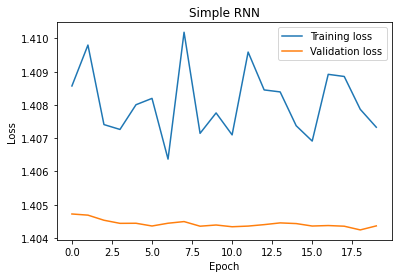

In [ ]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(range(num_epochs), train_loss, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Simple RNN')
plt.savefig("loss_graph_full_attention_tokens.png")
plt.show()

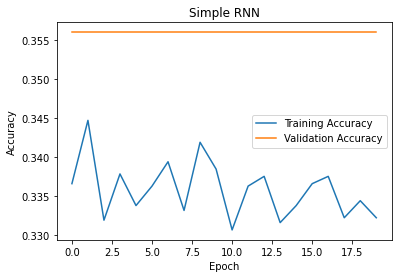

In [ ]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(range(num_epochs), train_acc, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('Simple RNN')

plt.savefig("accuracy_graph_full_attention_tokens.png")
plt.show()

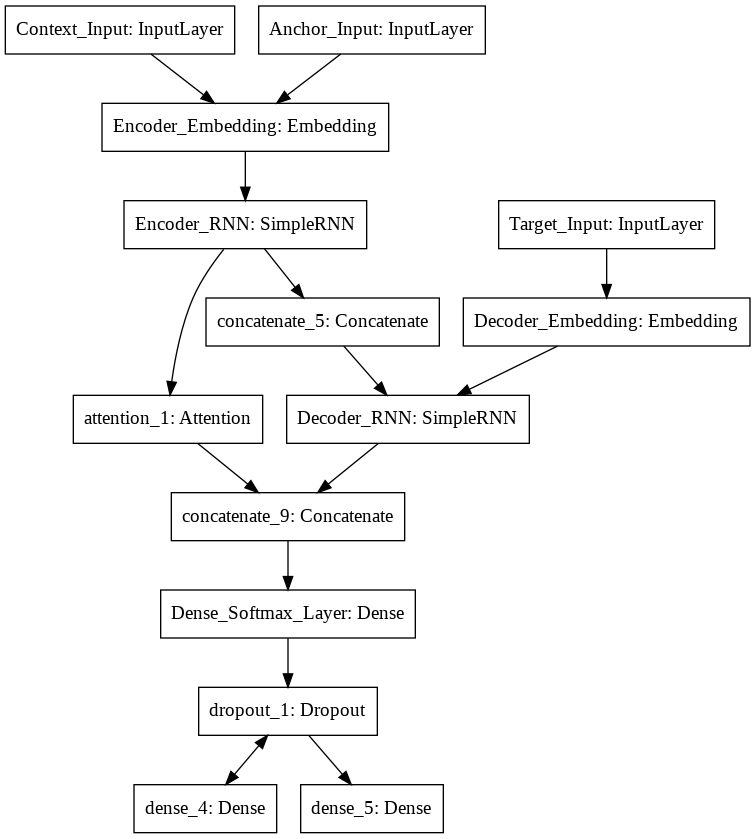

In [ ]:
keras.utils.plot_model(model, to_file="Model_Graph.png")

In [16]:
# print(model2_input1)

model2 = keras.models.Model([model2_input1, decoder2_input], decoder2_output)

model2.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ['accuracy'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    2711100     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    2711100     ['input_2[0][0]']                
                                                                                              

In [17]:
history2 = model2.fit([encoder_input1, decoder_input_2], output_decoder, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                     validation_data=([encoder_input1_val, decoder_input_2_val], output_decoder_val))

Epoch 1/10
365/365 [==============================] - 202s 533ms/step - loss: 4.0065 - accuracy: 0.3612 - val_loss: 1.3387 - val_accuracy: 0.4266
Epoch 2/10
365/365 [==============================] - 194s 533ms/step - loss: 3.8036 - accuracy: 0.4551 - val_loss: 1.5958 - val_accuracy: 0.4731
Epoch 3/10
365/365 [==============================] - 194s 530ms/step - loss: 3.5831 - accuracy: 0.5137 - val_loss: 1.7713 - val_accuracy: 0.4783
Epoch 4/10
365/365 [==============================] - 193s 530ms/step - loss: 3.3464 - accuracy: 0.5415 - val_loss: 2.3113 - val_accuracy: 0.4799
Epoch 5/10
365/365 [==============================] - 194s 531ms/step - loss: 3.1310 - accuracy: 0.5650 - val_loss: 2.7315 - val_accuracy: 0.4914
Epoch 6/10
365/365 [==============================] - 194s 531ms/step - loss: 2.9375 - accuracy: 0.5841 - val_loss: 3.2519 - val_accuracy: 0.4810
Epoch 7/10
365/365 [==============================] - 193s 528ms/step - loss: 2.8096 - accuracy: 0.5984 - val_loss: 3.7733 -

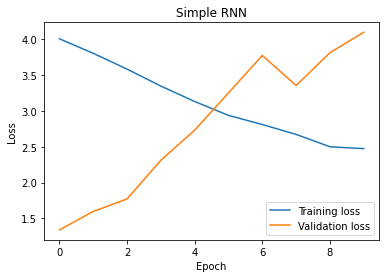

In [19]:
train_loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
plt.plot(range(num_epochs), train_loss, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Simple RNN')
plt.savefig("loss_graph_full_attention_tokens.png")
plt.show()

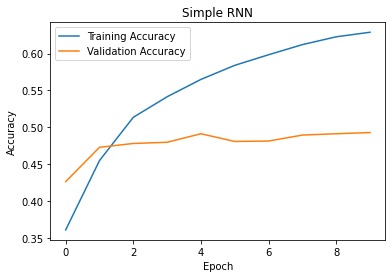

In [20]:
train_acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
plt.plot(range(num_epochs), train_acc, val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title('Simple RNN')

plt.savefig("accuracy_graph_full_attention_tokens.png")
plt.show()

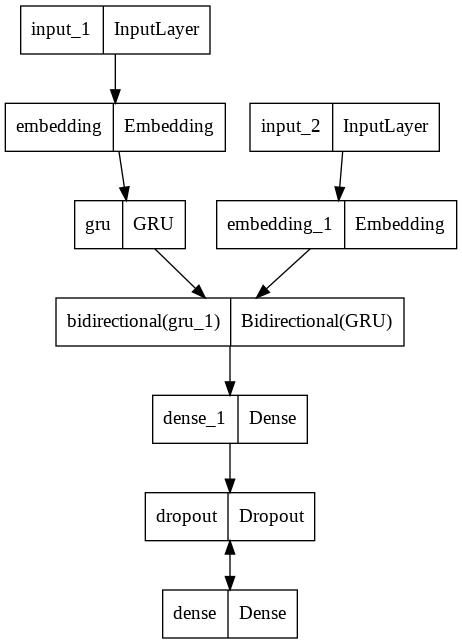

In [21]:
keras.utils.plot_model(model2, to_file="Model_Graph.png")

### Testing

In [ ]:
predictions = model.predict([encoder_input1_ver, encoder_input2_ver, input_decoder_ver])
predictions = np.argmax(predictions, axis=1)

print(predictions)

correlation = np.corrcoef(predictions/4, output_decoder_ver/4)
print(correlation[0][1])

# print(np.mean(val_acc))

In [22]:
predictions = model2.predict([encoder_input1_ver, decoder_input_2_ver])
predictions = np.argmax(predictions, axis=1)

print(predictions[predictions==4])

correlation = np.corrcoef(predictions/4, output_decoder_ver/4)
print(correlation[0][1])

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4]
0.41261357886572064


Best so far: 0.41261357886572064

In [29]:
model2.save("seq2class")

INFO:tensorflow:Assets written to: seq2class/assets


INFO:tensorflow:Assets written to: seq2class/assets


### Ensemble Method

In [74]:
display(data_ver)

,anchor,target,context,anchor_context,target_context
1373,androgen receptor modulators,testosterone receptor modulators,C07,androgen receptor modulators c07,testosterone receptor modulators c07
8107,crank,spring,F42,crank f42,spring f42
21533,obtain from fractions,generate keyword,C07,obtain from fractions c07,generate keyword c07
2350,auxiliary water,additional water,D06,auxiliary water d06,additional water d06
27125,recover from reaction product,recycle from reaction product,C08,recover from reaction product c08,recycle from reaction product c08
...,...,...,...,...,...
622,adaptive linear,fixed pattern,G01,adaptive linear g01,fixed pattern g01
6316,component composite coating,base coat,C08,component composite coating c08,base coat c08
12151,expandable scaffold,expanded stent structure,A61,expandable scaffold a61,expanded stent structure a61
24792,portable radio communication,radio communication unit,H01,portable radio communication h01,radio communication unit h01


In [25]:
bow_model = keras.models.load_model("BOW_model")

In [26]:
class_model1 = keras.models.load_model("model1")
class_model2 = keras.models.load_model("model2")

In [77]:
def one_hot(y):
    arr = np.zeros((y.shape[0], np.max(y) + 1))
    for i in range(arr.shape[0]):
        arr[i, y[i]] = 1
    return arr

#preprocess for model 1
def model1_preprocess(data_test, id):
    def preprocess1(df, id):
        data = df.to_numpy()
        if id:
            all_ids = data[:, 0]
            sentences = [data[i, 1].lower() + " " + data[i, 2].lower() + " " + data[i, 3].lower() for i in range(len(data))]
        else:
            sentences = [data[i, 0].lower() + " " + data[i, 1].lower() + " " + data[i, 2].lower() for i in range(len(data))]
        classes = {0: 0, .25: 1, .5: 2, .75: 3, 1: 4}
        return sentences

    m1_data = preprocess1(data_test, id)
    X_train = preprocess1(train_data, False)

    tk = Tokenizer()
    tk.fit_on_texts(X_train)
    # X_train = tk.texts_to_sequences(X_train)
    X_test = tk.texts_to_sequences(m1_data)
    X_test = pad_sequences(X_test,maxlen=111, padding="post")
    return X_test

# print(X_test)
X_test = model1_preprocess(data_ver, False)
preds1 = class_model1.predict(X_test)
preds1 = np.argmax(preds1, axis=1)
print(preds1)

correlation = np.corrcoef(preds1, output_decoder_ver)
print(correlation[0][1])



[2 1 0 ... 2 2 2]
0.5906148696527521


In [81]:
#Get predictions for Bag of Words Model
from nltk.stem import PorterStemmer
from collections import defaultdict

def bow_preprocess(data_test):
    train_data['anchor_context'] = train_data['anchor'].str.lower() + " " + train_data['context'].str.lower()
    train_data['target_context'] = train_data['target'].str.lower() + " " + train_data['context'].str.lower()
    data_test['anchor_context'] = data_test['anchor'].str.lower() + " " + data_test['context'].str.lower()
    data_test['target_context'] = data_test['target'].str.lower() + " " + data_test['context'].str.lower()

    anchor_context = train_data['anchor_context'].to_numpy()
    target_context = train_data['target_context'].to_numpy()
    anchor_context_ver = data_test['anchor_context'].to_numpy()
    target_context_ver = data_test['target_context'].to_numpy()
    max_anchor_len = max([len(sentence) for sentence in anchor_context])
    max_target_len = max([len(sentence) for sentence in target_context])
    maxlen = max(max_anchor_len, max_target_len)
    # print(maxlen)

    tk = Tokenizer()
    tk.fit_on_texts(np.concatenate((anchor_context, target_context), axis=0))
    anchor_token = tk.texts_to_sequences(anchor_context_ver)
    target_token = tk.texts_to_sequences(target_context_ver)

    def count_num_duplicate_stems(arr, threshold=2):
        _, counts = np.unique(arr, return_counts=True)
        return np.count_nonzero(counts >= threshold)

    X_test_anchor = pad_sequences(anchor_token, maxlen=maxlen, padding='post')
    X_test_target = pad_sequences(target_token, maxlen=maxlen, padding='post')
    ps = PorterStemmer()
    sentences = (data_test['anchor'] + " " + data_test['target']).to_numpy()
    stems = [[ps.stem(w) for w in sentence.split()] for sentence in sentences]
    counts = np.array([count_num_duplicate_stems(stems) for stems in stems]).reshape(-1, 1)
    return X_test_anchor, X_test_target, counts

X_test_anchor, X_test_target, counts = bow_preprocess(data_ver)
preds2 = bow_model.predict([X_test_anchor, X_test_target, counts])
preds2 = np.argmax(preds2, axis=1)

print(preds2)

correlation = np.corrcoef(preds2, output_decoder_ver)
print(correlation[0][1])


[2 1 0 ... 2 2 2]
0.7655037396465498


In [88]:
def ensemble_pred(pred1, pred2, pred3):
    #max vote

    def vote(tup):
        val = np.max([tup.count(tup[0]), tup.count(tup[1]), tup.count(tup[2])])
        if val == 1:
            return tup[2]
        else:
            i = np.argmax([tup.count(tup[0]), tup.count(tup[1]), tup.count(tup[2])])
            return tup[i]

        return tup[2]

    tupes = [(a,b,c) for a,b,c in tqdm(list(zip(pred1,pred2,pred3)))]
    # print(vote(tupes[0]))
    predictions = [vote(t) for t in tupes]


    return predictions

In [89]:
ensemble_predictions = ensemble_pred(predictions, preds1, preds2)
print(ensemble_predictions)

correlation = np.corrcoef(ensemble_predictions, output_decoder_ver)
print(correlation[0][1])

  0%|          | 0/5836 [00:00<?, ?it/s]

[2, 1, 0, 0, 2, 1, 2, 2, 2, 1, 0, 0, 2, 3, 1, 3, 2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 3, 2, 1, 1, 2, 0, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 3, 0, 1, 0, 2, 0, 1, 2, 0, 2, 3, 0, 2, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 1, 4, 3, 0, 2, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 3, 0, 1, 2, 0, 1, 2, 0, 2, 1, 3, 1, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 3, 0, 0, 2, 1, 1, 2, 2, 3, 0, 2, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 2, 1, 2, 3, 1, 3, 1, 1, 0, 2, 1, 0, 0, 3, 2, 2, 0, 3, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 3, 2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 3, 1, 2, 0, 0, 2, 2, 1, 1, 0, 2, 4, 3, 3, 1, 3, 1, 0, 2, 1, 2, 0, 2, 0, 1, 2, 3, 2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 3, 0, 1, 1, 2, 0, 3, 1, 1, 2, 3, 1, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1, 3, 1, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 3, 2, 2, 0, 2, 0, 2, 4, 2, 2, 3, 0, 

### Test Predictions

In [75]:
display(test_data)

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


In [85]:
X_test = model1_preprocess(test_data, True)
preds1_test = class_model1.predict(X_test)
preds1_test = np.argmax(preds1_test, axis=1)
print(preds1_test)

[2 2 2 1 0 2 2 2 1 4 1 0 0 3 3 2 0 2 3 2 2 1 1 1 2 0 0 0 0 3 0 0 2 2 1 1]


In [84]:
X_test_anchor, X_test_target, counts = bow_preprocess(test_data)
preds2_test = bow_model.predict([X_test_anchor, X_test_target, counts])
preds2_test = np.argmax(preds2_test, axis=1)

print(preds2_test)

[3 2 2 1 0 2 2 0 1 4 1 0 0 3 2 2 0 1 2 2 2 1 1 1 2 0 0 0 0 3 0 0 3 2 1 1]


In [86]:
anchor_test = test_data['anchor'].to_numpy()
target_test = test_data['target'].to_numpy()
context_test = test_data['context'].to_numpy()
test_set = [([token2idx[t] for t in tokenize(a)],[token2idx[t] for t in tokenize(b)],[token2idx[t] for t in ([c])]) for a,b,c in tqdm(list(zip(anchor_test, target_test, context_test)),desc="Processing Test Set:")]

encoder_input1_test = np.asarray([data[2] for data in test_set], dtype=np.int32)#context
encoder_input2_test = [data[0] for data in test_set]#anchor
encoder_input2_test = pad_sequences(encoder_input2_test, padding="post")
input_decoder_test = [data[1] for data in test_set]#target
input_decoder_test = pad_sequences(input_decoder_test)

decoder_input_2_test = [data[0]+data[1] for data in test_set]
decoder_input_2_test = pad_sequences(decoder_input_2_test, padding="post")

predictions_test = model2.predict([encoder_input1_test, decoder_input_2_test])
predictions_test = np.argmax(predictions_test, axis=1)

print(predictions_test)

Processing Test Set::   0%|          | 0/36 [00:00<?, ?it/s]

[2 1 1 1 0 2 2 1 1 3 1 1 0 2 3 2 2 1 2 2 1 1 1 1 2 1 0 0 2 1 0 0 3 2 1 1]


In [94]:
ensemble_predictions = ensemble_pred(predictions_test, preds1_test, preds2_test)

ensemble_predictions = np.array(ensemble_predictions)/4

print(ensemble_predictions)

  0%|          | 0/36 [00:00<?, ?it/s]

[0.5  0.5  0.5  0.25 0.   0.5  0.5  0.   0.25 1.   0.25 0.   0.   0.75
 0.75 0.5  0.   0.25 0.5  0.5  0.5  0.25 0.25 0.25 0.5  0.   0.   0.
 0.   0.75 0.   0.   0.75 0.5  0.25 0.25]


In [98]:
final = pandas.DataFrame()
final["id"] = test_data['id']
final['score'] = ensemble_predictions

display(final)

final.to_csv('submission.csv')

,id,score
0,4112d61851461f60,0.50
1,09e418c93a776564,0.50
2,36baf228038e314b,0.50
3,1f37ead645e7f0c8,0.25
4,71a5b6ad068d531f,0.00
5,474c874d0c07bd21,0.50
6,442c114ed5c4e3c9,0.50
7,b8ae62ea5e1d8bdb,0.00
8,faaddaf8fcba8a3f,0.25
9,ae0262c02566d2ce,1.00
